## The Sugarscape.

The "Sugarscape" is a landscape (in the form of a lattice) where **sugar grows in each cell**.

The sugar provides energy and wealth.

**Agents explore the landscape** and, while doing it, harvest the sugar. 

- Each round, each agent move once. They move sequentially. Each round, the order in which the agent move is random.

- Two agents can't share the same cell: if an agent can't move on a free cell within its range, it remains in the cell it occupies.

- Each agent pays a metabilic cost to remain alive and move on the sugarscape. When their energy (that corresponds to their sugar level) falls below zero then they die of starvation.

At the end of each round, the **landscape regrowth the sugar** according to the growth rule $G_{\rm g}$.

In our implementation we also combine agents genetics randomly after a certain amount of time. In order to analyze which traits are better suited for survival. 

### Features of the Sugarscape.

We start from the classical implementation: 

- squared lattice $N \times N$

- sugar full capacity of each cell: from 0 to 4

- landscape shaped like two sugar-hills

- rule $G_{\infty}$: at the end of each round, the sugar regrowth instantly to the maximum capacity of each cell.


### Agents on the Sugarscape.

Agents on sugarsape have the following features:

- vision: $v$ (uniform distribution $\in \{1, 2, ..., 6 \}$)
- sugar: $s$ (uniform distribution $\in \{5, 6, ... 25 \}$)
- metabolism: $m$ (uniform distribution $\in \{1, 2, 3, 4 \}$)

The vision determines the motion range.

The sugar is a reservoir of energy.

The metabolism represents the enegy each agents demands per round to survive. 



In [1]:
import numpy as np
import pandas as pd
from random import sample

In [2]:
def move_agents(SuSca, agents, N, max_vision=3):
    """
    Function to move the agents on the sugarscape using a pandas DataFrame.
    Implements one round where all agents move once, ensuring no two agents occupy the same cell.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the sugarscape (sugar levels at each position).
    agents : pandas DataFrame containing agent attributes and positions.
    N : Size of the sugarscape grid (NxN).
    max_vision : Maximum vision range for agents.

    Returns
    =======
    Updated sugarscape grid and agents DataFrame.
    """
    Nx, Ny = SuSca.shape
    SuSca = SuSca.copy()
    
    # Shuffle agent order to randomize movement
    agents = agents.sample(frac=1).reset_index(drop=True)
    
    # Create a set of occupied cells (x, y)
    occupied_cells = set(zip(agents["x"], agents["y"]))
    
    for i, agent in agents.iterrows():
        # Get agent's properties
        x, y = agent["x"], agent["y"]   # position of the agent 
        vision = int(agent["vision"] * max_vision)  # Scale vision to an integer
        sugar = agent["sugar"]
        metabolism = agent["metabolism"]
        
        # Determine visible cells within vision range
        visible_positions = []
        for dx in range(-vision, vision + 1):
            for dy in range(-vision, vision + 1):
                if abs(dx) + abs(dy) <= vision:  # Manhattan distance
                    new_x = int((x + dx) % Nx)
                    new_y = int((y + dy) % Ny)
                    if (new_x, new_y) not in occupied_cells:  # Skip occupied cells
                        visible_positions.append((new_x, new_y))
        
        if not visible_positions:
            # No valid moves; this agent is stuck
            continue
        
        # Find the cell with the highest sugar within vision
        # Here it might be possible to add a new lambda key, representing radiation for example. 
        best_cell = max(
            visible_positions,
            key=lambda pos: SuSca[pos[0], pos[1]]
        )
        
        # Move agent to the best cell
        new_x, new_y = best_cell
        agents.at[i, "x"] = new_x
        agents.at[i, "y"] = new_y
        
        # Update occupied cells
        occupied_cells.remove((x, y))  # Free the old cell
        occupied_cells.add((new_x, new_y))  # Mark the new cell as occupied
        
        # Collect sugar from the new cell
        agents.at[i, "sugar"] += SuSca[new_x, new_y]
        SuSca[new_x, new_y] = 0  # Deplete the cell's sugar
        
        # Pay the metabolic cost
        agents.at[i, "sugar"] -= metabolism
    
    # Remove agents with sugar <= 0 (they "die"), then reset the index of the DataFrame
    agents = agents[agents["sugar"] > 0].reset_index(drop=True)
    
    return SuSca, agents


Initialize the sugarscape in the "classical" way.

In [3]:
import numpy as np

def initialize_sugarscape(N):
    """
    Function to generate the "classical" sugarscape.
    
    Parameters
    ==========
    N : Side of the sugarscape lattice.
    """
    
    # Initialize SuSca with integer values
    SuSca = np.zeros([N, N], dtype=int)  # Ensure the matrix is integer
    
    # Create grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    # Define the center locations for the sugar sources
    x_centers = np.array([N / 4, 3 * N / 4])
    y_centers = np.array([N / 4, 3 * N / 4])

    # Define the radius levels and sugar levels
    r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
    s_levels = np.array([1, 2, 3, 4])
    
    # Loop through the centers and assign sugar values
    for k in range(np.size(x_centers)):
        # Calculate distance from the center to each point on the grid
        d = np.sqrt((X - x_centers[k]) ** 2 + (Y - y_centers[k]) ** 2)
        
        # Loop through the sugar levels
        for i in range(np.size(s_levels)):
            # Determine the region within the radius and assign sugar levels
            region = np.where(d <= r_levels[i])
            SuSca[region[0], region[1]] = s_levels[i]
    
    return SuSca

#print(initialize_sugarscape(10))


Function to convert a 2 dimensional numpy array into a RGB image.

In [4]:
def convert2RBG(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Check whether the initialization works.

In [5]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.

SuSca = initialize_sugarscape(N)

# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [6]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 100  # Number of agents on the sugarscape.

# Random positions for agents (each agent occupies a different cell)
positions = np.array(sample(range(N * N), A)).astype(int)
x_positions = positions % N
y_positions = positions // N

# Create the agents, randomly assigning the values of sugar, metabolism, vision and positions. 
agents = pd.DataFrame({
    "sugar": np.random.uniform(0, 1, A),       # Random sugar values
    "metabolism": np.random.uniform(0, 1, A), # Random metabolism values
    "vision": np.random.uniform(0, 1, A),     # Random vision values, Maybe change this since the vision requires integer numbers? 
    "fitness": np.zeros(A),                   # Initialize fitness to 0
    "x": x_positions,                         # X-coordinate of agent
    "y": y_positions                          # Y-coordinate of agent
})


print(agents)

# Initialize the sugarscape
SuSca = initialize_sugarscape(N)


       sugar  metabolism    vision  fitness   x   y
0   0.738078    0.976984  0.683243      0.0  36  29
1   0.029835    0.991945  0.622342      0.0  18  34
2   0.145507    0.672627  0.816074      0.0  27  49
3   0.821589    0.576395  0.573522      0.0   5  43
4   0.480274    0.770968  0.121157      0.0   5  24
..       ...         ...       ...      ...  ..  ..
95  0.602717    0.106389  0.798314      0.0   9  39
96  0.641616    0.444364  0.716489      0.0  45  22
97  0.714069    0.467293  0.377348      0.0  26  10
98  0.981559    0.672639  0.314280      0.0  29  14
99  0.390302    0.810592  0.367599      0.0  11  16

[100 rows x 6 columns]


In [7]:
import time 
from tkinter import Tk
from tkinter import Canvas

r0 = 0.25
N_skip = 1

# Visualize status every N_skip steps. 
window_size = 600

cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
tk.attributes('-topmost', 0)
canvas.place(x=10, y=10, height=window_size, width=window_size)

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.
while running:

    nSuSca, nA = move_agents(SuSca, agents, N)  ###############################

    # Update animation frame.
    if step % N_skip == 0:        
        canvas.delete('all')
        SU_cells = []
        for i in range(N):
            for j in range(N):
                cell_color = cell_color_list[int(nSuSca[i, j])]
                #
                SU_cells.append(
                    canvas.create_rectangle(
                        i / N * window_size, 
                        j / N * window_size,
                        (i + 1) / N * window_size,
                        (j + 1) / N * window_size, 
                        outline='', 
                        fill=cell_color,
                    )
                )
        
        
        Agents_circ = []
        for _, agent in agents.iterrows():  # Iterating through each row in the DataFrame
            x = agent["x"]  # X-coordinate of the agent
            y = agent["y"]  # Y-coordinate of the agent
            
            # Drawing the agent as a circle
            Agents_circ.append(
                canvas.create_oval(
                    (x + 0.5 - r0) / N * window_size,  # Top-left x-coordinate
                    (y + 0.5 - r0) / N * window_size,  # Top-left y-coordinate
                    (x + 0.5 + r0) / N * window_size,  # Bottom-right x-coordinate
                    (y + 0.5 + r0) / N * window_size,  # Bottom-right y-coordinate
                    outline='', 
                    fill='#000000',
                )
            )

        
        tk.title(f'Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(0.5)  # Increase to slow down the simulation.

    agents = nA
    step += 1
    
tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).

TclError: invalid command name ".!canvas"

Now let's try without animation.

In [11]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Agents initialized. 
M = np.random.randint(np.size(possible_m), size=A) + 1
V = np.random.randint(np.size(possible_v), size=A) + 1
S = np.random.randint(np.size(possible_s), size=A) + 5

M0 = M.copy()
S0 = S.copy()
V0 = V.copy()

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

SuSca = initialize_sugarscape(N)

# Number of agents
num_agents = 400

# Create a DataFrame with random values for each attribute
agents = pd.DataFrame({
    "sugar": np.random.uniform(0, 1, num_agents),       # Random sugar values
    "metabolism": np.random.uniform(0, 1, num_agents), # Random metabolism values
    "vision": np.random.uniform(0, 1, num_agents),     # Random vision values
    "fitness": np.zeros(num_agents)                    # Initialize fitness to 0
})


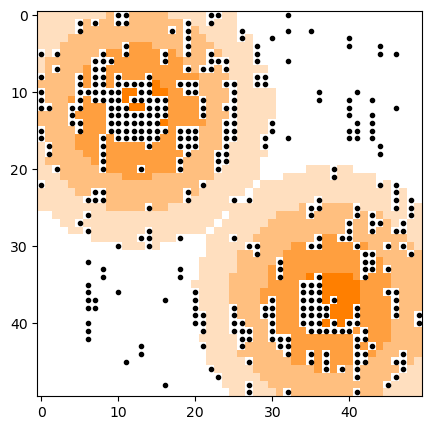

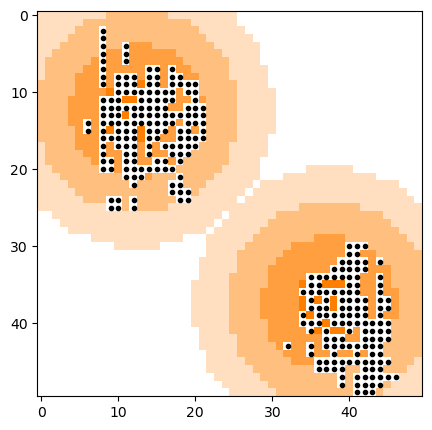

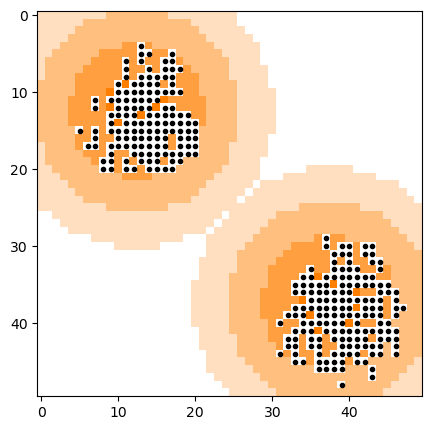

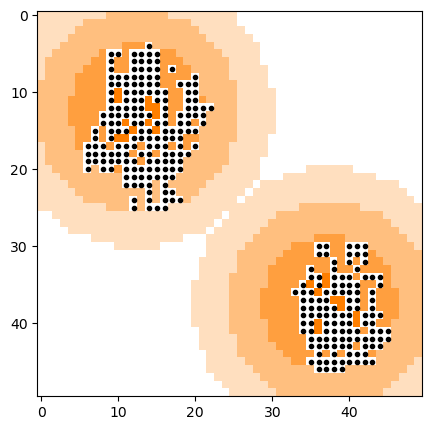

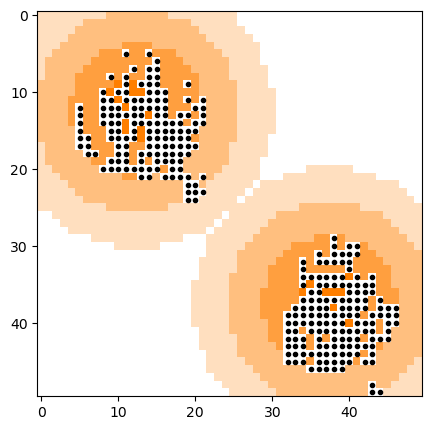

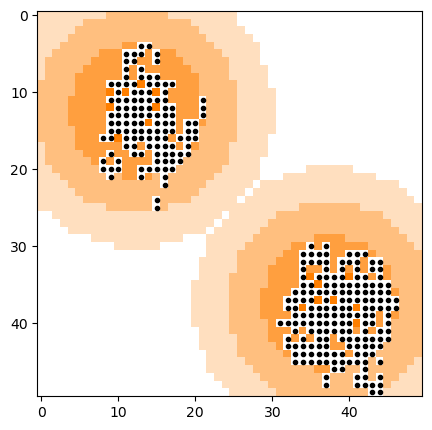

In [12]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 1001
N_skip = 200
step = 0

N_alive_agents = np.zeros(MAX_STEP)


running = True  # Flag to control the loop.
while running:

    N_alive_agents[step] = A

    nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

    if step % N_skip == 0:   
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(ny, nx, '.', color='k')
        plt.show()
    
    
    A = nA
    V = nV.copy()
    S = nS.copy()
    M = nM.copy()
    x = nx.copy()
    y = ny.copy()
    step += 1
    
    if step >= MAX_STEP:
        running = False

        
# Final Values
M1 = M.copy()
S1 = S.copy()
V1 = V.copy()



Compare histograms:

In [ ]:
print(A)

301


#### Metabolism

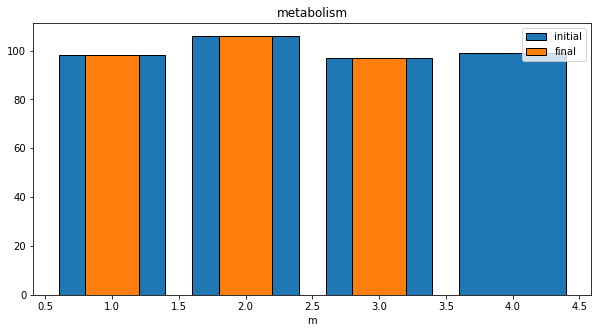

In [ ]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





#### Vision

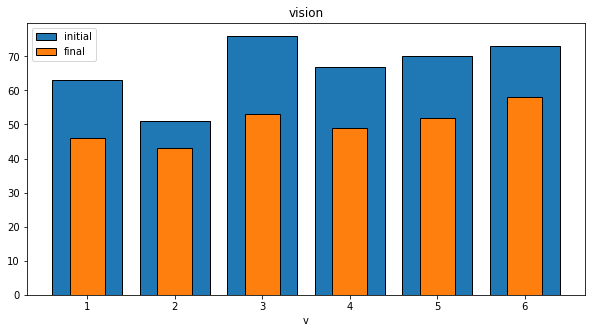

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

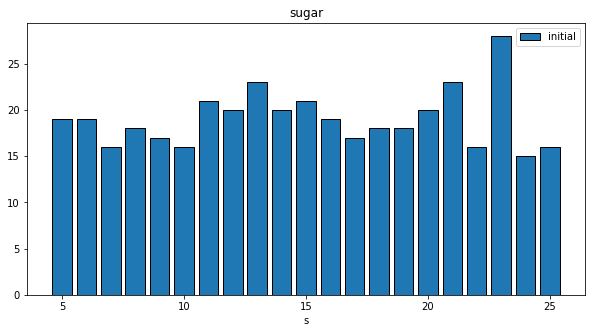

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

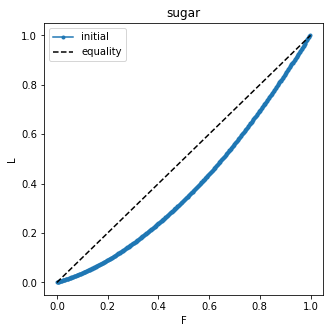

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


